In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

%matplotlib inline 


import random

In [2]:
class RBF_Net(object):
    def __init__(self):
        return 
    
    def C_init(self, X_train, N):
        kmeans = KMeans(n_clusters = N, random_state=0, max_iter = 40)
        kmeans.fit(X_train)
        return kmeans.cluster_centers_
    
    def fit(self, X_train, Y_train, N):
        self.X = X_train
        self.Y = Y_train.T
        self.C = self.C_init(self.X, N)
        
        self.d = self.d_constr(self.C)
        self.F = self.F_constr(self.X, self.C, self.d)
        self.Wb = self.train(self.Y, self.F)
        
        self.y_dim = len(Y_train[0])
        self.x_dim = len(X_train[0])

    def d_constr(self, C):
        N = len(C)
        d = np.zeros(N)
        l = np.zeros(N)
        
        for i in tqdm(range(N),"Distant progress"):
            for j in range(N):
                l[j] = np.linalg.norm(C[i] - C[j])
            d[i] = np.std(l)
        return d

    def F_constr(self, X, C, d):
        S = len(X)
        N = len(C)
        F = np.zeros((N, S))
        for i in tqdm(range(N),"F progress"):
            for j in range(S):
                F[i][j] = np.linalg.norm(X[j] - C[i])
            F[i] = (F[i]) #/ d[i]
        #F = np.exp(-(F**(1/8)))
        #F = F**(1/3)
        return F
        
    def FA_const(self, F):
        a = np.ones((1, len(F[0])))
        return np.vstack((F, a))
        
    def train(self, Y, F):
        FA = self.FA_const(F)
        
        FAFAT =tf.linalg.matmul(FA, FA, transpose_b=True)

        self.mu = np.linalg.cond(tf.make_ndarray(tf.make_tensor_proto(FAFAT)))
        FAFAT = tf.linalg.pinv(FAFAT, rcond = 10**(-100), validate_args = True)
        Wb =  tf.linalg.matmul(Y, FA, transpose_b=True)
        Wb =  tf.linalg.matmul(Wb, FAFAT)
        
        Wb = tf.make_tensor_proto(Wb)
        Wb = tf.make_ndarray(Wb)
        
        print('Train complete')
        
        return Wb
        
        
        
    def predict(self, X):
        F = self.F_constr(X, self.C, self.d)
        FA = self.FA_const(F)
        Y_pr = np.dot(self.Wb, FA)
        return Y_pr.T       
    pass

In [3]:
def weighting(X, func_type, angl):
    
    N = len(X[0])
    k = (angl[1] - angl[0]) / (N - 1)
    
    angles_pi = np.zeros(N)
    angles = np.zeros(N)
    
    
    for i in range(N):
        angles_pi[i] = (angl[0] + k * i ) * np.pi / 180
        angles[i] = angl[0] + k * i
        
    if func_type == 'sin':
        weight = np.sin(angles_pi[i])
        return X*weight

    if func_type == 'sin^2':
        weight = np.sin(angles_pi[i]) ** 2
        return X*weight

    if func_type == 'sin^4':
        weight = np.sin(angles_pi[i]) ** 4
        return X*weight

    if func_type == 'log':
        return np.log(X)

    if func_type == 'm_func':
        weight = np.copy(angles)
        for i in range(len(angles)):
            if angles[i] == 0:
                weight[i] = 0
            if (angles[i] > 0):
                weight[i] = (np.exp(-2*(np.log(angles[i]/54.0))**2))/angles[i]
        return X * weight

def cutter(X, start, end):
    return X[:,start:end+1]

In [4]:
def predict_plot(y_test, y_pred, params):
    N = len(params)
    
    plt.figure(figsize=(20,20))
    
    for i in range (N):
        for j in range(N):
            if i == j:
                plt.subplot(N, N, i*N+j+1)
                plt.title("Предсказание с помощью сетей")
                plt.xlabel(params[i]+' Тестовые')
                plt.ylabel(params[i]+' Предсказанные')
                
                plt.plot(y_test[:,i], y_pred[:,i] ,'*', label = "Тест")
                
                plt.legend()
            else:
                plt.subplot(N, N, i*N+j+1)
                plt.title("Предсказание с помощью сетей")
                plt.xlabel(params[i])
                plt.ylabel(params[j])

                plt.plot(y_test[:,i], y_test[:,j] ,'*', label = "Тест")
                plt.plot(y_pred[:,i], y_pred[:,j], '.', label = "Предсказание")
                plt.legend()


def error_plot(y_test, y_pred, params):
    
    N = len(params)
    
    error = []
    for j in range(len(y_pred[0])):
        buf_err = []    
        for i in range(len(y_pred)):
            buf_err.append((y_test[i,j]-y_pred[i,j]))   
        error.append(buf_err)


    plt.figure(figsize=(20,20))
    
    for i in range (N):
        
        plt.subplot(N, 2, i*2+1)
        plt.title("Ошибка предсказания %s" %(params[i]))
        plt.ylabel("Ошибка предсказания %s" %(params[i]))
        plt.xlabel("Номер индикатрисы")
        plt.plot(error[i],'*')
        
    
        plt.subplot(N, 2, i*2+2)
        plt.title("Распределение ошибки %s" %(params[i]))
        plt.xlabel("Ошибка предсказания %s" %(params[i]))
        plt.hist(error[i], 100)
        plt.text(0,0,'mu = %f \n sigma = %f' %(np.mean(error[i]),np.std(error[i])),bbox=dict(facecolor='white'))

    return error

In [5]:
col_list = ['r' ,'n']
for i in range(181):
    col_list.append(str(i))

df = pd.read_csv('spheres', delimiter = '\t', names = col_list)
df_test = pd.read_csv('random_spheres', delimiter = '\t', names = col_list)

In [6]:
y_train = np.array(df)[:, :2]
x_train = (np.array(df)[:,2:])

y_test = np.array(df_test)[:, :2]
x_test = (np.array(df_test)[:,2:])

x_train = weighting(x_train, 'm_func', [0,180])
x_test = weighting(x_test, 'm_func', [0,180])

x_train = cutter(x_train, 10 , 70)
x_test = cutter(x_test, 10 , 70)

In [7]:
def optimize(v, bd_x, bd_y):
    N = len(bd_x)
    optima_id = 0
    MSE_map = np.zeros(N)
    first = np.linalg.norm(v)
    for i in range(N):
        MSE_map[i] = np.linalg.norm(bd_x[i] - v)
        if first > MSE_map[i]:
            first = MSE_map[i]
            optima_id = i
            
    return (bd_x[optima_id],bd_y[optima_id])

In [8]:
rbf = RBF_Net()
rbf.fit(x_train, y_train, 1000)
y_pred = rbf.predict(x_test)

F progress: 100%|██████████████████████████| 1000/1000 [00:18<00:00, 53.65it/s]


Train complete


F progress: 100%|██████████████████████████| 1000/1000 [01:32<00:00, 10.76it/s]


# Предсказание с использованием RBF
## 500 центров (C),
## d = std() 
## 10 - 70 градусов, 
## шаг 1 градус, 
## бесшумный случай

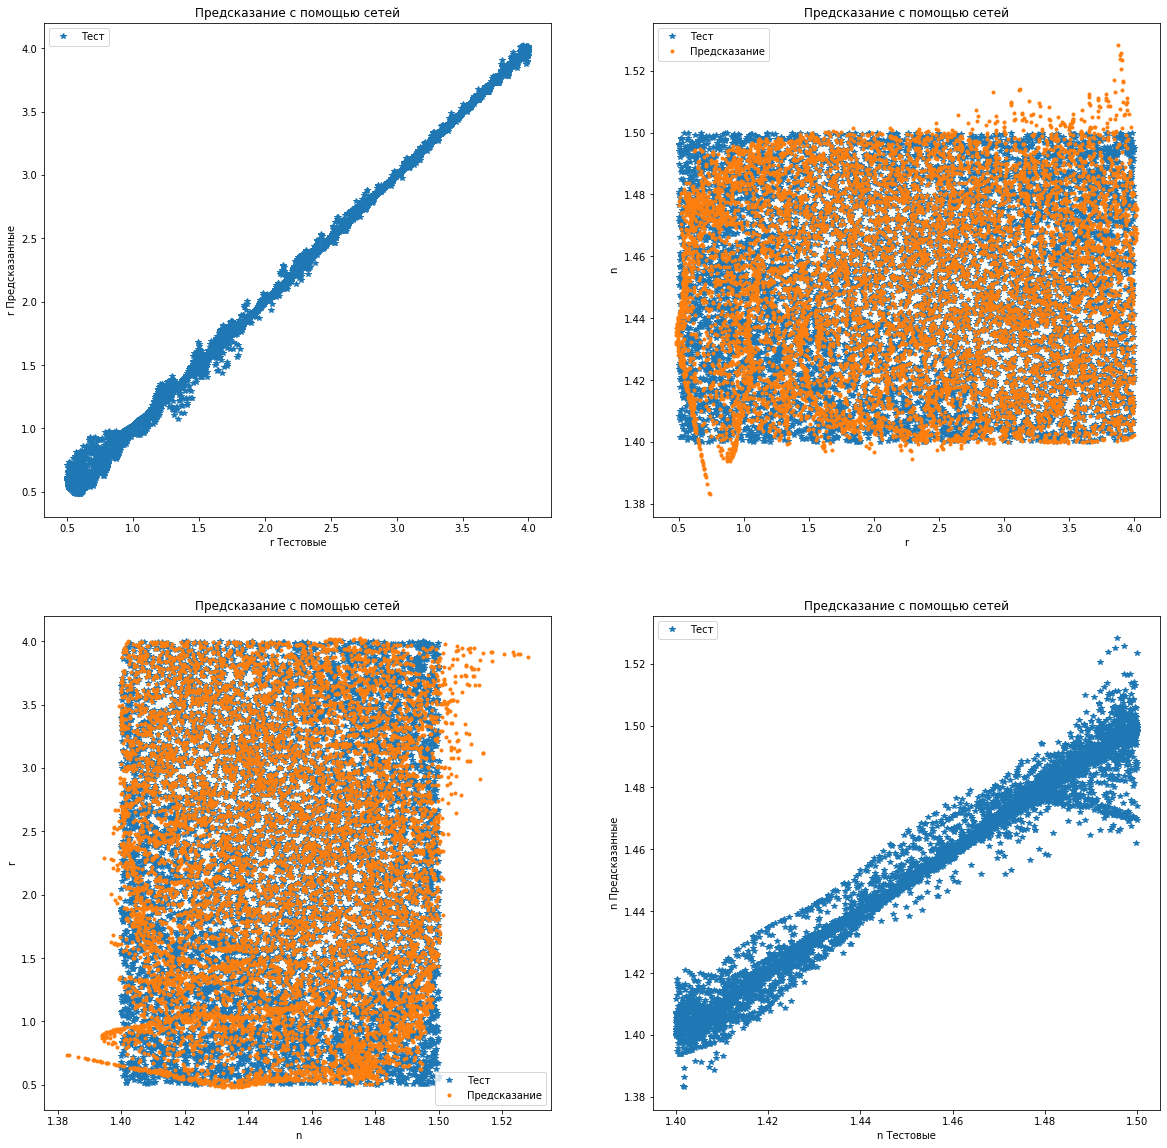

In [9]:
predict_plot(y_test, y_pred, ['r','n'])

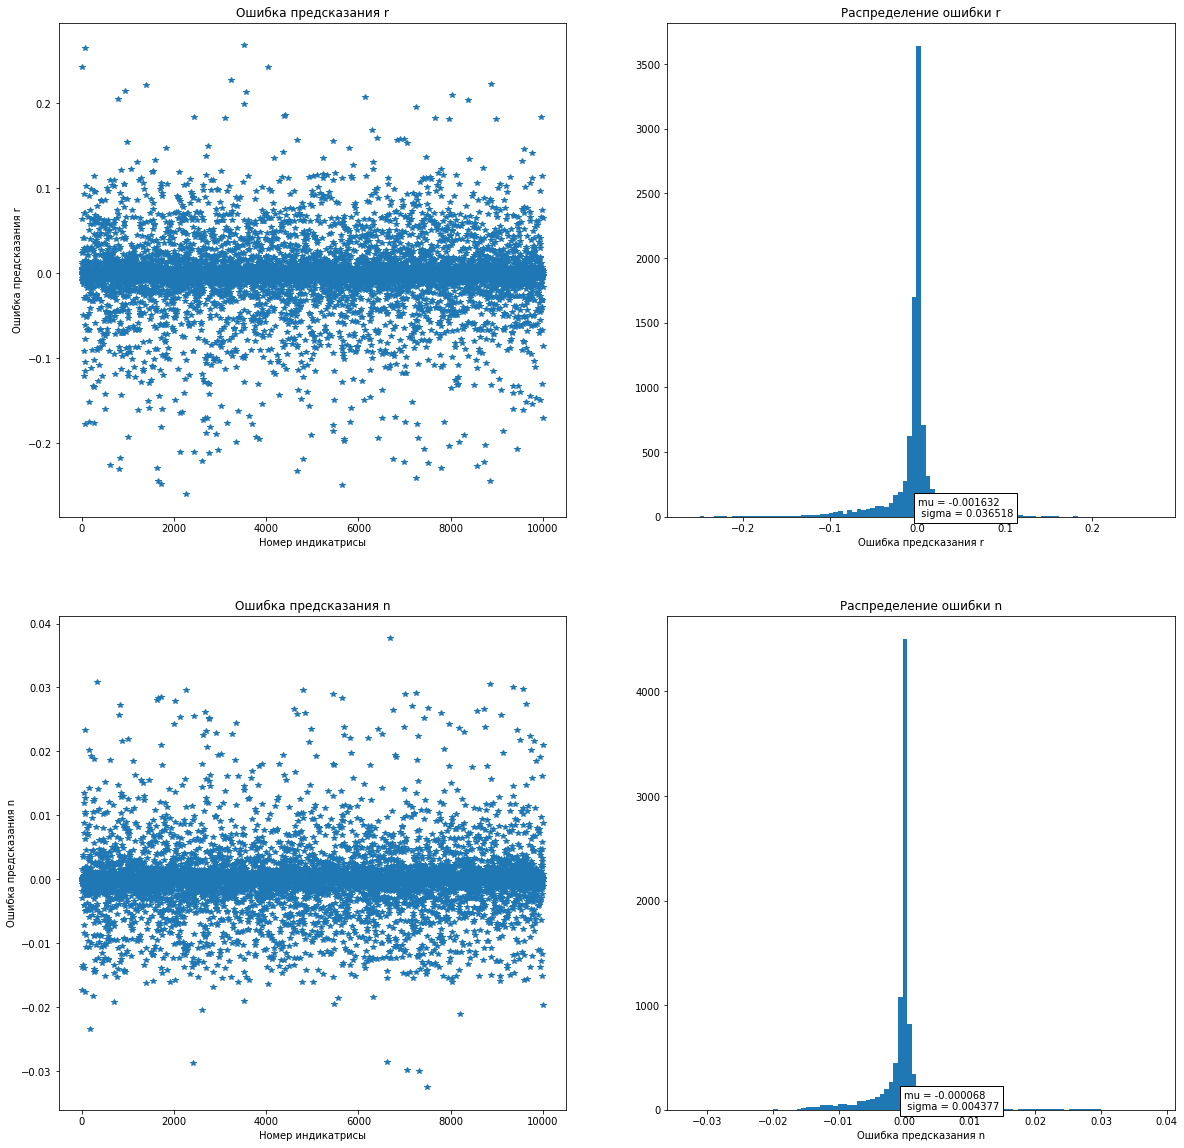

In [10]:
errors = error_plot(y_test, y_pred,['r','n'])

In [11]:
x_test_noise = np.copy(x_test)
for i in range(len(x_test_noise)):
    sigma = np.max((x_test_noise[i])) * 0.05
    for j in range(len(x_test_noise[i])):
        x_test_noise[i][j] = np.random.normal(x_test_noise[i][j], sigma)

In [12]:
y_pred_noise = rbf.predict(x_test_noise)

F progress: 100%|██████████████████████████| 1000/1000 [01:31<00:00, 10.88it/s]


# Предсказание с использованием RBF
## 500 центров (C),
## d = std()
## 10 - 70 градусов, 
## шаг 1 градус, 
## Сигма шум 0.02

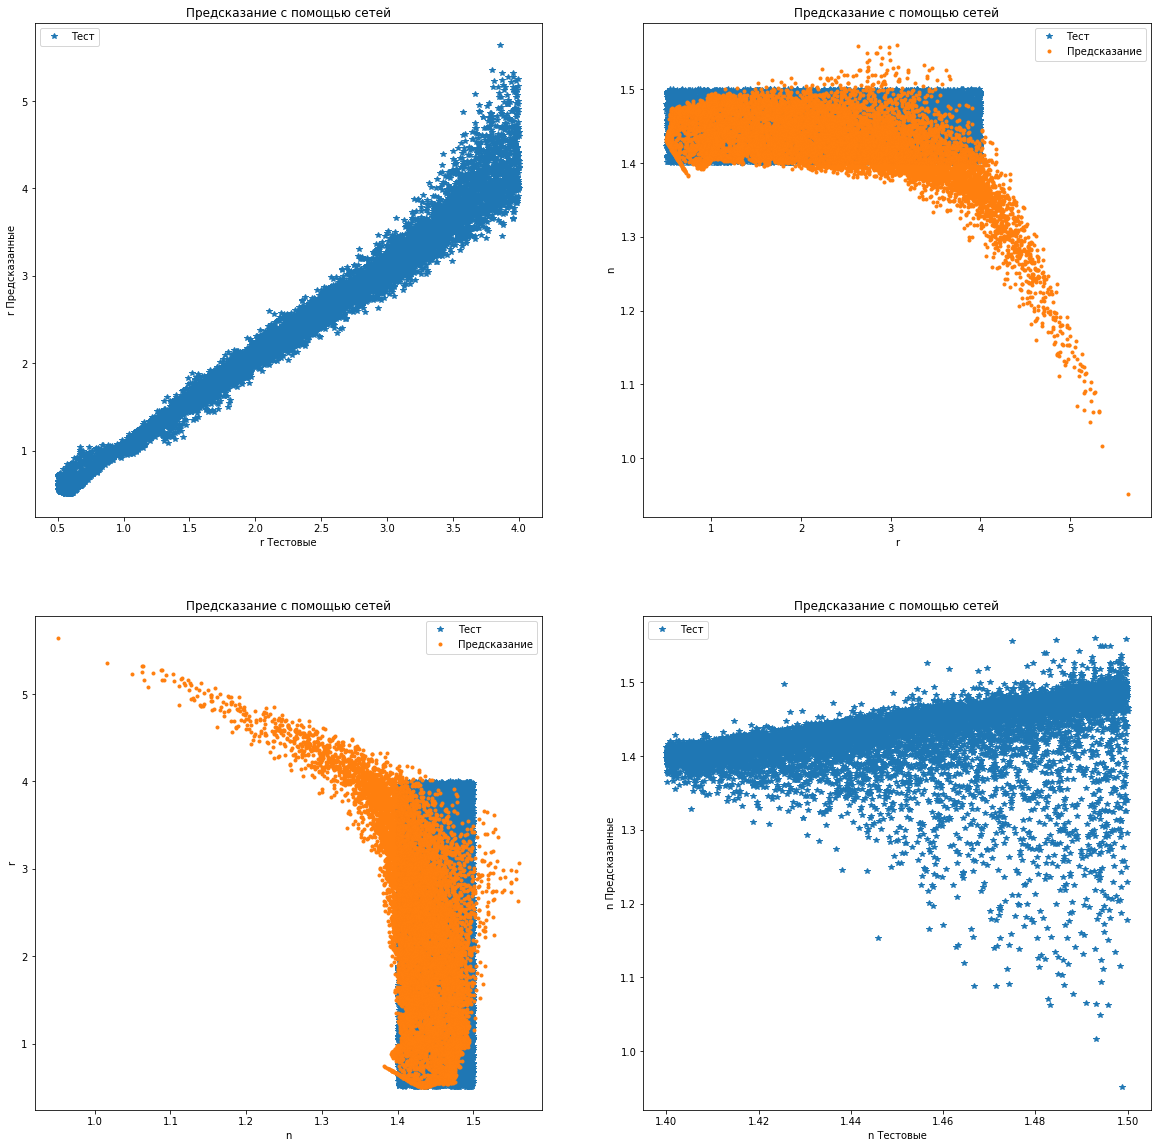

In [13]:
predict_plot(y_test, y_pred_noise, ['r','n'])

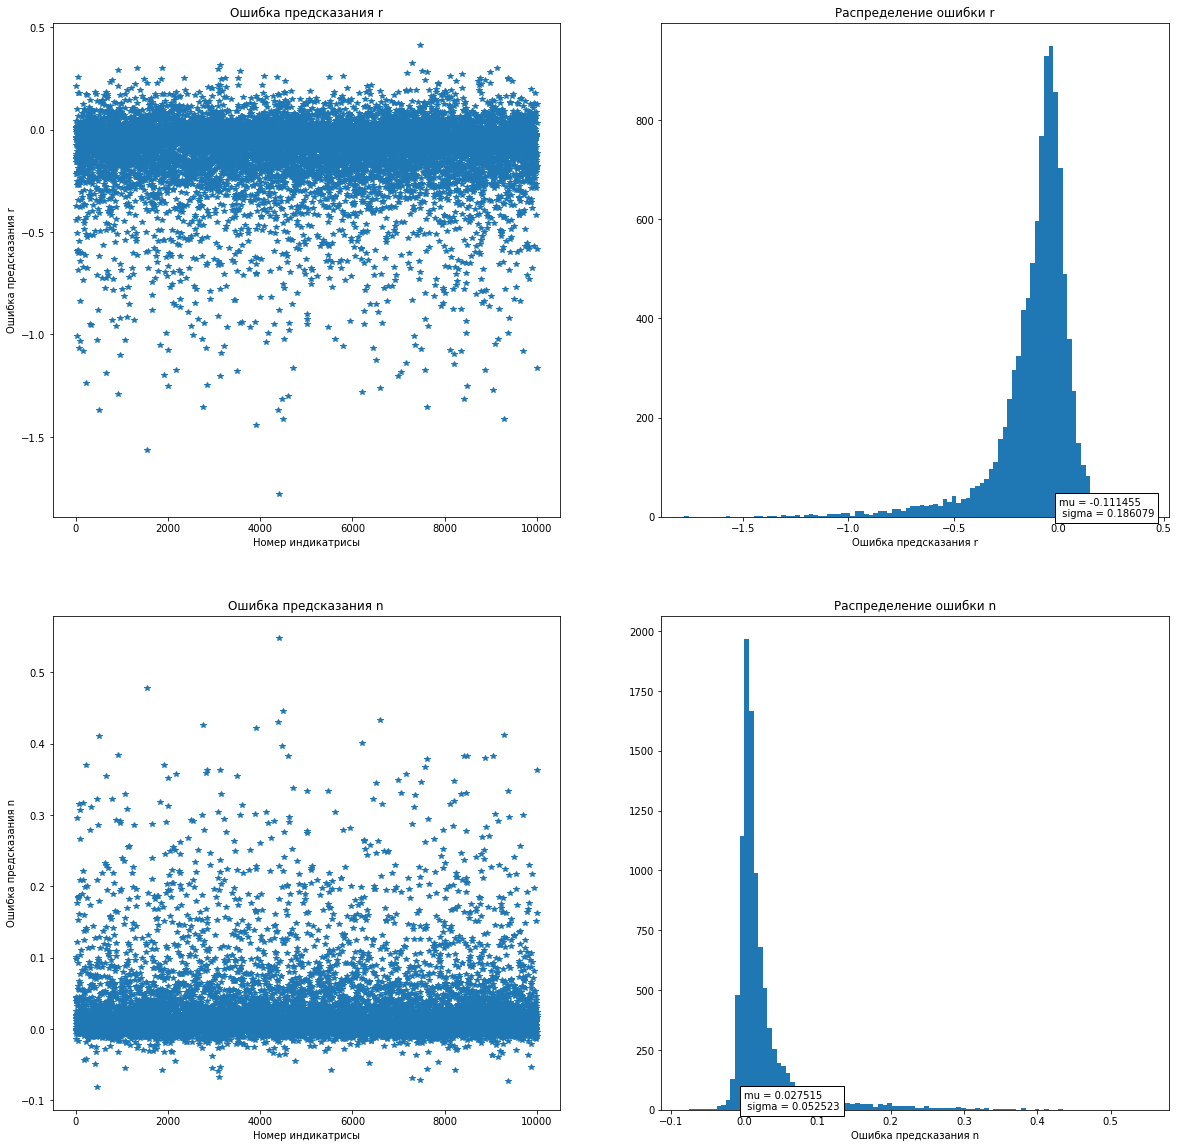

In [14]:
errors = error_plot(y_test, y_pred_noise,['r','n'])

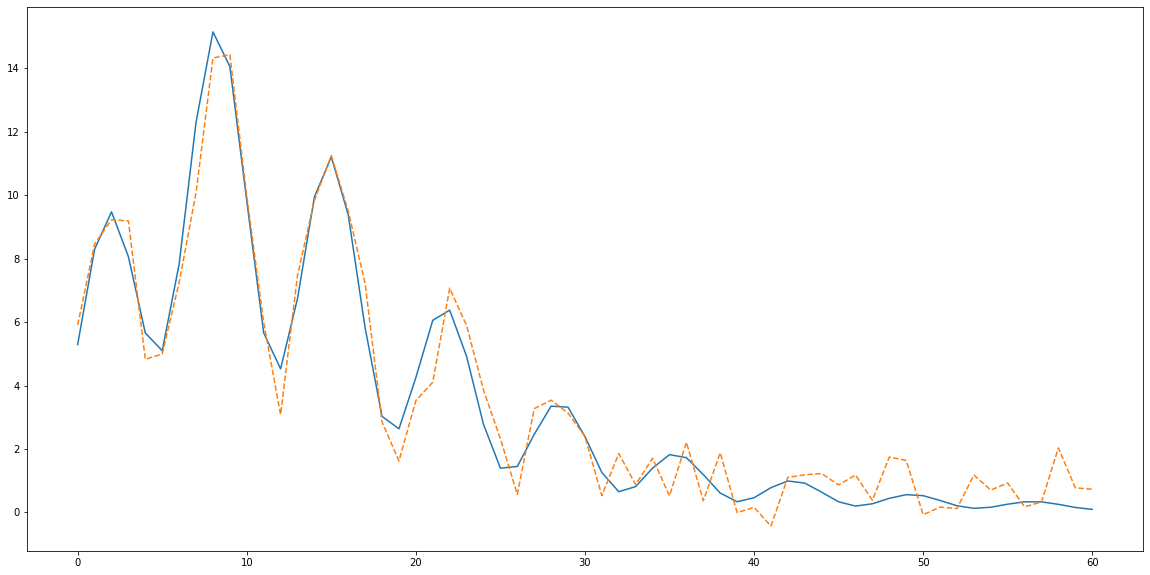

In [15]:
plt.figure(figsize=(20,10))
plt.plot(x_test[10],'-',x_test_noise[10],'--')